# pass data to the database Mongodb and postgres 

In [1]:


from dagster import resource, op, job
from pymongo import MongoClient
from pydantic import AnyUrl
from pydantic_settings import BaseSettings
import json
import pandas as pd
from sqlalchemy import create_engine
from urllib.parse import quote_plus

from dagster import In

class MongoDsn(AnyUrl):
    allowed_schemes = {"mongodb", "mongodb+srv"}

class Settings(BaseSettings):
    mongo_uri: MongoDsn = MongoDsn("mongodb://127.0.0.1:27017")
    username: str = 'postgres'
    password: str = 'Test@1234'
    host: str = 'localhost'
    port: str = '5433'
    database: str = 'postgres'
    encoded_password: str = quote_plus(password)
    postgres_uri: str = f"postgresql://{username}:{encoded_password}@{host}:{port}/{database}"

    class Config:
        env_file = ".env"

@resource(config_schema={"mongo_uri": str, "postgres_uri": str})
def db_resource(context):
    mongo_client = MongoClient(context.resource_config["mongo_uri"])
    postgres_engine = create_engine(context.resource_config["postgres_uri"])
    return {"mongo": mongo_client["DAP"], "postgres": postgres_engine}

@op(required_resource_keys={"db"}, config_schema={"file_path": str, "collection_name": str})
def load_json_to_mongo(context):
    file_path = context.op_config["file_path"]
    collection_name = context.op_config["collection_name"]
    collection = context.resources.db["mongo"][collection_name]
    try:
        with open(file_path) as f:
            data = json.load(f)
        if isinstance(data, dict):
            data = [data]
        result = collection.insert_many(data)
        context.log.info(f"Inserted {len(result.inserted_ids)} records into MongoDB collection '{collection_name}'")
    except Exception as e:
        context.log.error(f"Error inserting data into collection '{collection_name}': {e}")
        raise

@op(required_resource_keys={"db"}, config_schema={"file_path": str})
def load_csv_to_postgres(context):
    file_path = context.op_config["file_path"]
    postgres_engine = context.resources.db["postgres"]
    try:
        data = pd.read_csv(file_path)
        data.to_sql('pollution', con=postgres_engine, if_exists='replace', index=False)
        context.log.info("CSV data loaded into PostgreSQL successfully")
    except Exception as e:
        context.log.error(f"Error loading CSV data into PostgreSQL: {e}")
        raise

@job(resource_defs={"db": db_resource})
def data_ingestion_job():
    load_json_emissions = load_json_to_mongo.configured(
        {
            "file_path": r"C:\\Users\\malav\\OneDrive\\Desktop\\DAP_14_12_2024\\emissionsUSA.json",
            "collection_name": "emissions"
        },
        name="load_json_emissions"
    )
    load_json_heartcare = load_json_to_mongo.configured(
        {
            "file_path": r"C:\\Users\\malav\\OneDrive\\Desktop\\DAP_14_12_2024\\Heart_Care_and_Hospital_Data.json",
            "collection_name": "heartcare"
        },
        name="load_json_heartcare"
    )
    load_csv_pollution = load_csv_to_postgres.configured(
        {
            "file_path": r"C:\\Users\\malav\\OneDrive\\Desktop\\DAP_14_12_2024\\pollution_2000_2023.csv"
        },
        name="load_csv_pollution"
    )

    load_json_emissions()
    load_json_heartcare()
    load_csv_pollution()

if __name__ == "__main__":
    settings = Settings()
    data_ingestion_job.execute_in_process(
        run_config={
            "resources": {
                "db": {
                    "config": {
                        "mongo_uri": str(settings.mongo_uri),
                        "postgres_uri": settings.postgres_uri
                    }
                }
            }
        }
    )


2024-12-16 03:07:34 +0000 - dagster - DEBUG - data_ingestion_job - 400b2ce1-b3b1-4d6e-88ee-94854da4ad0f - 27620 - RUN_START - Started execution of run for "data_ingestion_job".
2024-12-16 03:07:34 +0000 - dagster - DEBUG - data_ingestion_job - 400b2ce1-b3b1-4d6e-88ee-94854da4ad0f - 27620 - ENGINE_EVENT - Executing steps in process (pid: 27620)
2024-12-16 03:07:34 +0000 - dagster - DEBUG - data_ingestion_job - 400b2ce1-b3b1-4d6e-88ee-94854da4ad0f - 27620 - RESOURCE_INIT_STARTED - Starting initialization of resources [db, io_manager].
2024-12-16 03:07:34 +0000 - dagster - DEBUG - data_ingestion_job - 400b2ce1-b3b1-4d6e-88ee-94854da4ad0f - 27620 - RESOURCE_INIT_SUCCESS - Finished initialization of resources [db, io_manager].
2024-12-16 03:07:34 +0000 - dagster - DEBUG - data_ingestion_job - 400b2ce1-b3b1-4d6e-88ee-94854da4ad0f - 27620 - LOGS_CAPTURED - Started capturing logs in process (pid: 27620).
2024-12-16 03:07:34 +0000 - dagster - DEBUG - data_ingestion_job - 400b2ce1-b3b1-4d6e-88ee

# fetch data from MongoDB

In [2]:
 
from pymongo import MongoClient
import pandas as pd


client = MongoClient("mongodb://localhost:27017/")


db = client['DAP']


emissions_collection = db['emissions']
emissions_data = emissions_collection.find({})  
emissions_df = pd.DataFrame(list(emissions_data))


heartcare_collection = db['heartcare']
heartcare_data = heartcare_collection.find({}) 
heartcare_df = pd.DataFrame(list(heartcare_data))


print("Emissions DataFrame:")
print(emissions_df.head()) 
print("\nHeartcare DataFrame:")
print(heartcare_df.head())  


client.close()


Emissions DataFrame:
                        _id  year state-name  \
0  675f99a553d8d27372d97b0c  1970    Alabama   
1  675f99a553d8d27372d97b0d  1970    Alabama   
2  675f99a553d8d27372d97b0e  1970    Alabama   
3  675f99a553d8d27372d97b0f  1970    Alabama   
4  675f99a553d8d27372d97b10  1970    Alabama   

                                       sector-name    fuel-name       value  
0              Industrial carbon dioxide emissions         Coal   26.721507  
1              Industrial carbon dioxide emissions    Petroleum    3.577779  
2              Industrial carbon dioxide emissions  Natural Gas    8.944097  
3              Industrial carbon dioxide emissions    All Fuels   39.243383  
4  Total carbon dioxide emissions from all sectors    All Fuels  102.646851  

Heartcare DataFrame:
                        _id       full_name  age country          state  \
0  675f99a553d8d27372da6509   Alice Johnson   21     USA           Utah   
1  675f99a553d8d27372da650a    Bob Williams   44  

# fetch data from postgres

In [3]:
from sqlalchemy import create_engine
import pandas as pd
from urllib.parse import quote

# Database connection parameters
username = 'postgres'
password = quote('Test@1234')  
host = 'localhost'
port = '5433'
database = 'postgres'

# Create connection engine
engine = create_engine(f'postgresql://{username}:{password}@{host}:{port}/{database}')

# Load the entire table into a Pandas DataFrame
table_name = 'pollution'  
pollution_df = pd.read_sql_table(table_name, con=engine)

print(pollution_df.head())


   Unnamed: 0        Date                                  Address    State  \
0           0  2000-01-01  1645 E ROOSEVELT ST-CENTRAL PHOENIX STN  Arizona   
1           1  2000-01-02  1645 E ROOSEVELT ST-CENTRAL PHOENIX STN  Arizona   
2           2  2000-01-03  1645 E ROOSEVELT ST-CENTRAL PHOENIX STN  Arizona   
3           3  2000-01-04  1645 E ROOSEVELT ST-CENTRAL PHOENIX STN  Arizona   
4           4  2000-01-05  1645 E ROOSEVELT ST-CENTRAL PHOENIX STN  Arizona   

     County     City   O3 Mean  O3 1st Max Value  O3 1st Max Hour  O3 AQI  \
0  Maricopa  Phoenix  0.019765             0.040               10      37   
1  Maricopa  Phoenix  0.015882             0.032               10      30   
2  Maricopa  Phoenix  0.009353             0.016                9      15   
3  Maricopa  Phoenix  0.015882             0.033                9      31   
4  Maricopa  Phoenix  0.007353             0.012                9      11   

   ...  CO 1st Max Hour  CO AQI  SO2 Mean  SO2 1st Max Value  

In [4]:
pollution_df.columns

Index(['Unnamed: 0', 'Date', 'Address', 'State', 'County', 'City', 'O3 Mean',
       'O3 1st Max Value', 'O3 1st Max Hour', 'O3 AQI', 'CO Mean',
       'CO 1st Max Value', 'CO 1st Max Hour', 'CO AQI', 'SO2 Mean',
       'SO2 1st Max Value', 'SO2 1st Max Hour', 'SO2 AQI', 'NO2 Mean',
       'NO2 1st Max Value', 'NO2 1st Max Hour', 'NO2 AQI'],
      dtype='object')

In [5]:

pollution_df['Date'] = pd.to_datetime(pollution_df['Date'])
 
# Define the date range
start_date = '2018-01-01'
end_date = '2023-12-30'
 

pollution_df = pollution_df[(pollution_df['Date'] >= start_date) & (pollution_df['Date'] <= end_date)]
 

pollution_df.reset_index(drop=True, inplace=True)
 

print(pollution_df)
 

 

        Unnamed: 0       Date                                Address    State  \
0           495396 2018-03-13  NO. B'HAM,SOU R.R., 3009 28TH ST. NO.  Alabama   
1           495397 2018-03-14  NO. B'HAM,SOU R.R., 3009 28TH ST. NO.  Alabama   
2           495398 2018-03-29  NO. B'HAM,SOU R.R., 3009 28TH ST. NO.  Alabama   
3           495399 2018-03-30  NO. B'HAM,SOU R.R., 3009 28TH ST. NO.  Alabama   
4           495400 2018-03-31  NO. B'HAM,SOU R.R., 3009 28TH ST. NO.  Alabama   
...            ...        ...                                    ...      ...   
170013      665409 2023-06-26  NCore - North Cheyenne Soccer Complex  Wyoming   
170014      665410 2023-06-27  NCore - North Cheyenne Soccer Complex  Wyoming   
170015      665411 2023-06-28  NCore - North Cheyenne Soccer Complex  Wyoming   
170016      665412 2023-06-29  NCore - North Cheyenne Soccer Complex  Wyoming   
170017      665413 2023-06-30  NCore - North Cheyenne Soccer Complex  Wyoming   

           County        Ci

In [6]:

pollution_df['Date'] = pd.to_datetime(pollution_df['Date'])


In [7]:
pollution_df.drop(['Address','County','City'],axis=1,inplace=True)

In [8]:
pollution_df.drop(columns='Unnamed: 0', inplace=True)

In [9]:
pollution_df.dtypes

Date                 datetime64[ns]
State                        object
O3 Mean                     float64
O3 1st Max Value            float64
O3 1st Max Hour               int64
O3 AQI                        int64
CO Mean                     float64
CO 1st Max Value            float64
CO 1st Max Hour               int64
CO AQI                      float64
SO2 Mean                    float64
SO2 1st Max Value           float64
SO2 1st Max Hour              int64
SO2 AQI                     float64
NO2 Mean                    float64
NO2 1st Max Value           float64
NO2 1st Max Hour              int64
NO2 AQI                       int64
dtype: object

In [10]:
#
print("Dataset Overview:")
print(pollution_df.info())


Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170018 entries, 0 to 170017
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Date               170018 non-null  datetime64[ns]
 1   State              170018 non-null  object        
 2   O3 Mean            170018 non-null  float64       
 3   O3 1st Max Value   170018 non-null  float64       
 4   O3 1st Max Hour    170018 non-null  int64         
 5   O3 AQI             170018 non-null  int64         
 6   CO Mean            170018 non-null  float64       
 7   CO 1st Max Value   170018 non-null  float64       
 8   CO 1st Max Hour    170018 non-null  int64         
 9   CO AQI             170018 non-null  float64       
 10  SO2 Mean           170018 non-null  float64       
 11  SO2 1st Max Value  170018 non-null  float64       
 12  SO2 1st Max Hour   170018 non-null  int64         
 13  SO2 AQI            170018 

In [11]:

print("\nDescriptive Statistics:")
print(pollution_df.describe())



Descriptive Statistics:
             O3 Mean  O3 1st Max Value  O3 1st Max Hour         O3 AQI  \
count  170018.000000     170018.000000    170018.000000  170018.000000   
mean        0.029486          0.039009        10.717477      38.496400   
std         0.011330          0.013633         3.271054      19.509624   
min        -0.000706          0.000000         7.000000       0.000000   
25%         0.021294          0.030000         9.000000      28.000000   
50%         0.029412          0.038000        10.000000      35.000000   
75%         0.037412          0.047000        11.000000      44.000000   
max         0.083200          0.121000        23.000000     217.000000   

             CO Mean  CO 1st Max Value  CO 1st Max Hour         CO AQI  \
count  170018.000000     170018.000000    170018.000000  170018.000000   
mean        0.249926          0.346956         5.285876       3.853298   
std         0.170370          0.258531         7.433610       3.047362   
min        -

In [12]:

pollution_df['Year'] = pollution_df['Date'].dt.year
pollution_df['Month'] = pollution_df['Date'].dt.month


In [13]:
pollution_df

,Date,State,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,CO Mean,CO 1st Max Value,CO 1st Max Hour,CO AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI,Year,Month
0,2018-03-13,Alabama,0.041412,0.045,10,42,0.200000,0.2,16,2.0,0.161905,0.4,15,0.0,6.509524,22.2,5,21,2018,3
1,2018-03-14,Alabama,0.029882,0.050,9,46,0.200000,0.2,0,2.0,0.200000,0.3,7,0.0,11.057143,37.7,22,35,2018,3
2,2018-03-29,Alabama,0.033059,0.039,7,36,0.188889,0.2,16,2.0,0.580000,2.8,3,3.0,6.925000,18.4,16,17,2018,3
3,2018-03-30,Alabama,0.025294,0.043,11,40,0.120833,0.3,23,3.0,0.116667,2.6,23,3.0,6.112500,26.3,23,25,2018,3
4,2018-03-31,Alabama,0.032647,0.053,10,49,0.258333,0.4,2,5.0,1.495833,4.5,1,6.0,12.383333,33.7,19,31,2018,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170013,2023-06-26,Wyoming,0.043941,0.050,12,46,0.000000,0.0,0,0.0,0.117391,0.3,7,0.0,2.282609,4.3,6,4,2023,6
170014,2023-06-27,Wyoming,0.046235,0.054,12,50,0.000000,0.0,0,0.0,0.091667,0.2,8,0.0,2.283333,5.2,6,5,2023,6
170015,2023-06-28,Wyoming,0.046588,0.055,7,51,0.000000,0.0,0,0.0,0.091667,0.2,6,0.0,2.487500,4.8,19,4,2023,6
170016,2023-06-29,Wyoming,0.048765,0.056,9,54,0.000000,0.0,0,0.0,0.052174,0.1,8,0.0,2.086957,4.1,8,4,2023,6


# basic EDA of pollution

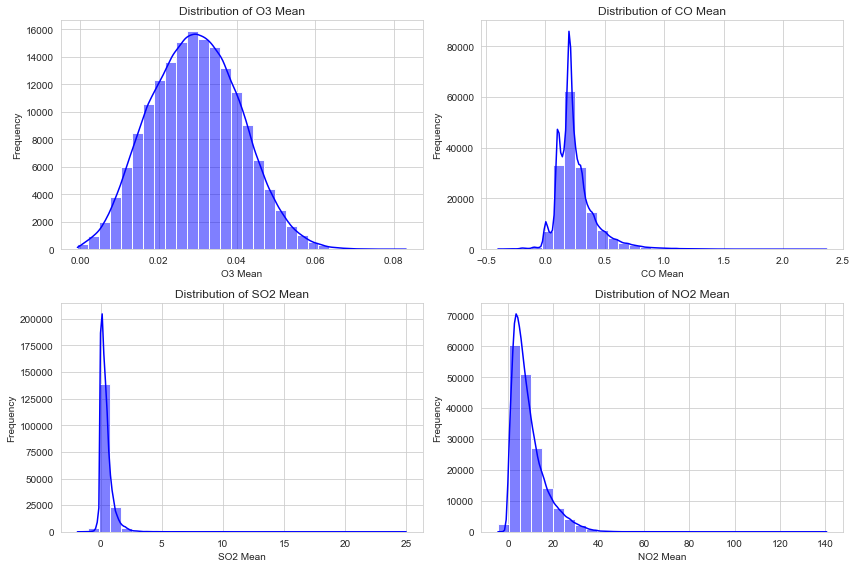

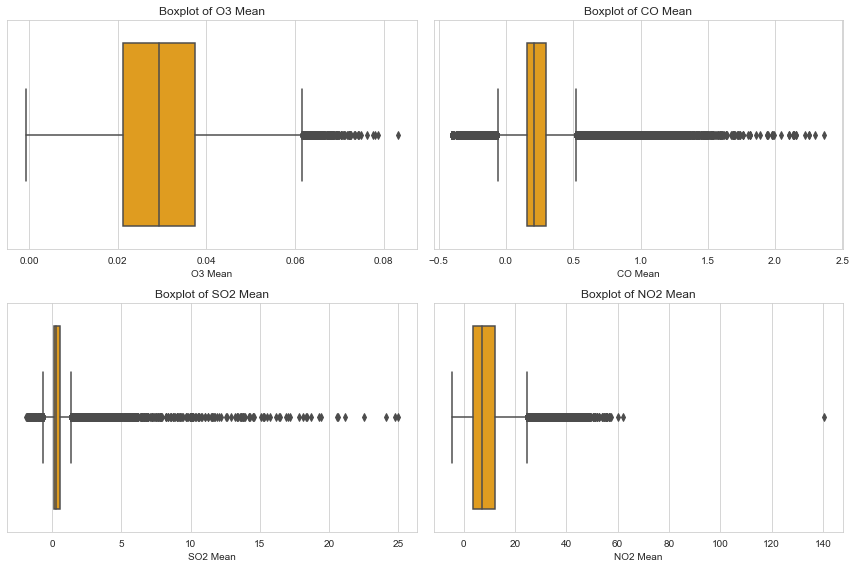

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
sns.set_style("whitegrid")

# Plot histograms for key pollutant variables
pollutants = ['O3 Mean', 'CO Mean', 'SO2 Mean', 'NO2 Mean']
plt.figure(figsize=(12, 8))
for i, col in enumerate(pollutants):
    plt.subplot(2, 2, i+1)
    sns.histplot(pollution_df[col], kde=True, bins=30, color="blue")
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Plot boxplots for key pollutant variables to detect outliers
plt.figure(figsize=(12, 8))
for i, col in enumerate(pollutants):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x=pollution_df[col], color="orange")
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
plt.tight_layout()
plt.show()

# Yearly trends of pollutants

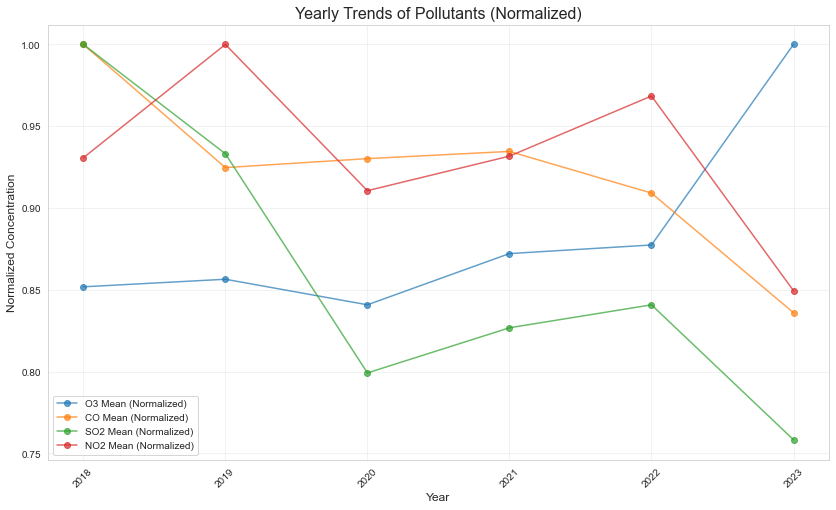

In [15]:
import matplotlib.pyplot as plt


yearly_data = pollution_df.groupby('Year')[['O3 Mean', 'CO Mean', 'SO2 Mean', 'NO2 Mean']].mean()


normalized_yearly_data = yearly_data / yearly_data.max()


plt.figure(figsize=(14, 8))
for pollutant in yearly_data.columns:
    plt.plot(normalized_yearly_data.index, normalized_yearly_data[pollutant], 
             label=f'{pollutant} (Normalized)', marker='o', alpha=0.7)


plt.title('Yearly Trends of Pollutants (Normalized)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Normalized Concentration', fontsize=12)
plt.xticks(yearly_data.index, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from IPython.display import display


state_dropdown = widgets.Dropdown(
    options=pollution_df['State'].unique(),
    description='State:',
    value='Alabama'  
)


def plot_yearly_trends(selected_state):
    
    state_data = pollution_df[pollution_df['State'] == selected_state]
    
    
    yearly_data = state_data.groupby('Year')[['O3 Mean', 'CO Mean', 'SO2 Mean', 'NO2 Mean']].mean()
    
    
    all_years = range(pollution_df['Year'].min(), pollution_df['Year'].max() + 1)
    yearly_data = yearly_data.reindex(all_years).fillna(0) 
    
    normalized_yearly_data = yearly_data / yearly_data.max()

    
    plt.figure(figsize=(14, 8))
    for pollutant in yearly_data.columns:
        plt.plot(normalized_yearly_data.index, normalized_yearly_data[pollutant], 
                 label=f'{pollutant} (Normalized)', marker='o', alpha=0.7)

    
    plt.title(f'Yearly Trends of Pollutants in {selected_state} (Normalized)', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Normalized Concentration', fontsize=12)
    plt.xticks(list(all_years), rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


interactive_plot = widgets.interactive(plot_yearly_trends, selected_state=state_dropdown)


display(interactive_plot)

interactive(children=(Dropdown(description='State:', options=('Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Cal…

In [17]:

seasonal_data = pollution_df.groupby('Month')[['O3 Mean', 'CO Mean', 'SO2 Mean', 'NO2 Mean']].mean()

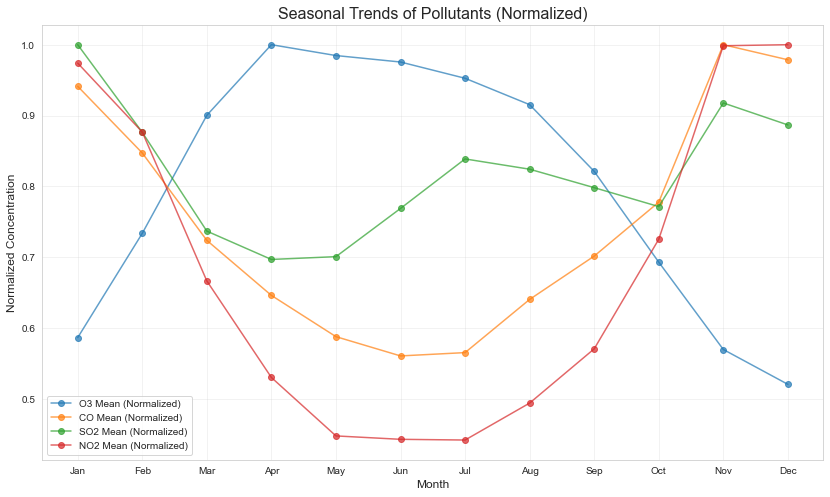

In [18]:

normalized_data = seasonal_data / seasonal_data.max()


plt.figure(figsize=(14, 8))
for pollutant in pollutants:
    plt.plot(normalized_data.index, normalized_data[pollutant], label=f'{pollutant} (Normalized)', marker='o', alpha=0.7)

plt.title('Seasonal Trends of Pollutants (Normalized)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Normalized Concentration', fontsize=12)
plt.xticks(range(1, 13), 
           labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


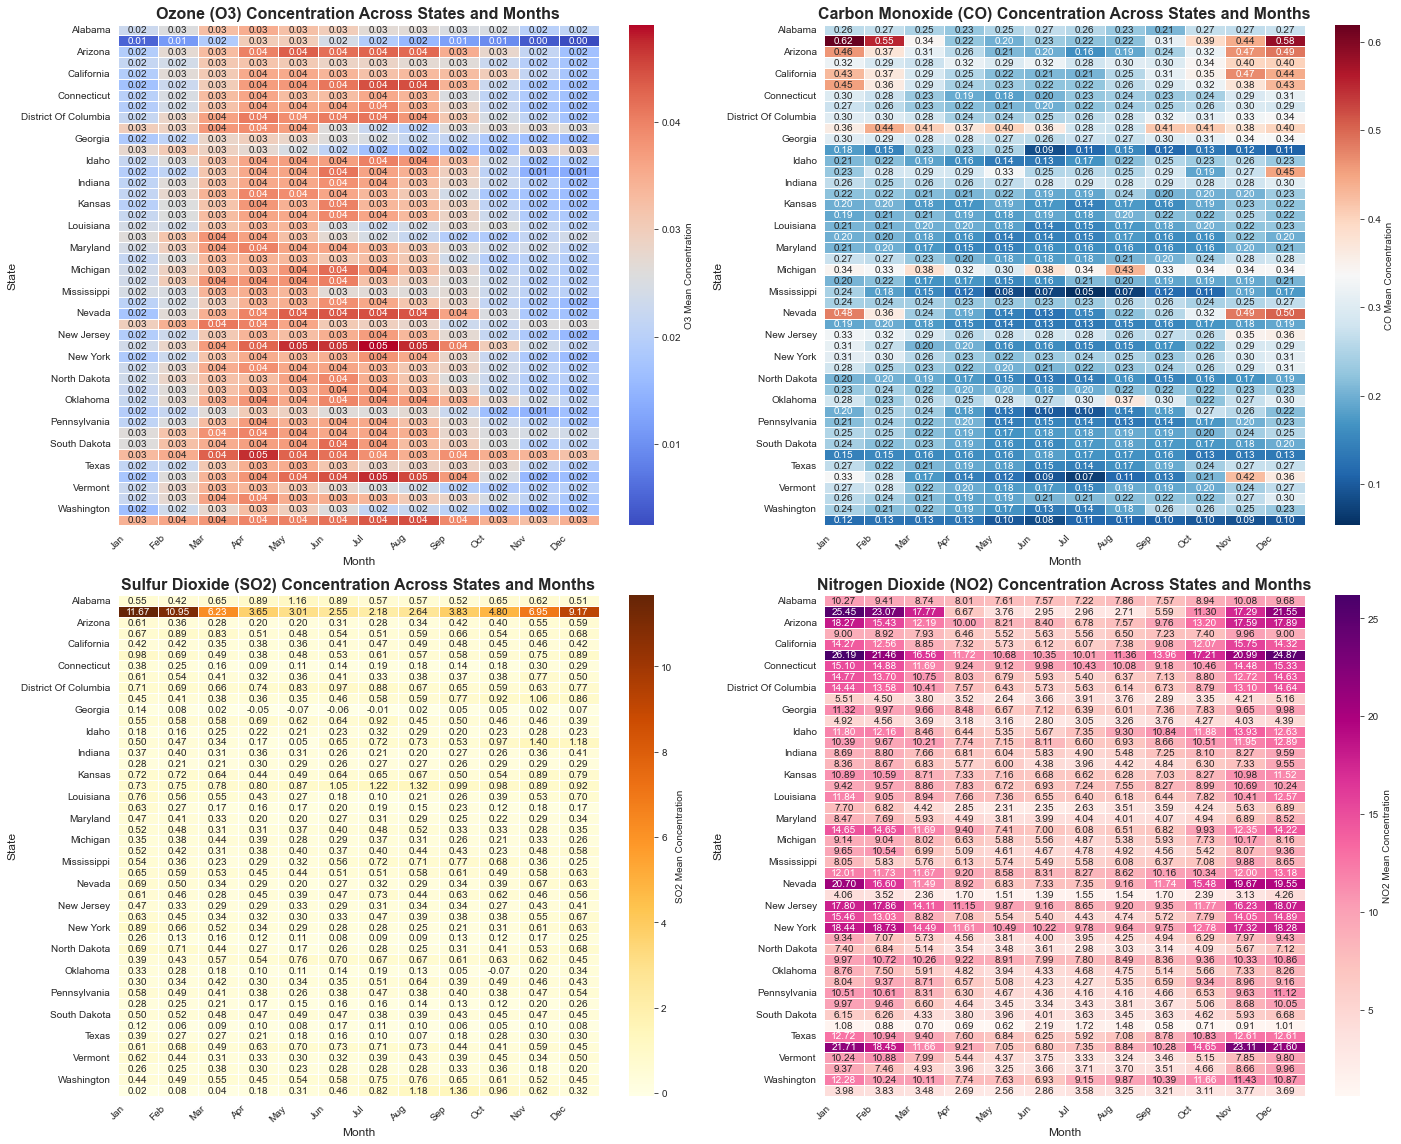

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


regional_seasonal_data = pollution_df.groupby(['State', 'Month'])[['O3 Mean', 'CO Mean', 'SO2 Mean', 'NO2 Mean']].mean().reset_index()


pollutants = ['O3 Mean', 'CO Mean', 'SO2 Mean', 'NO2 Mean']
titles = ['Ozone (O3)', 'Carbon Monoxide (CO)', 'Sulfur Dioxide (SO2)', 'Nitrogen Dioxide (NO2)']
color_palettes = ['coolwarm', 'RdBu_r', 'YlOrBr', 'RdPu']  

plt.figure(figsize=(20, 16))  
for i, (pollutant, title, cmap) in enumerate(zip(pollutants, titles, color_palettes), 1):
    
    heatmap_data = regional_seasonal_data.pivot(index='State', columns='Month', values=pollutant)
    
    
    plt.subplot(2, 2, i)  
    sns.heatmap(
        heatmap_data, 
        cmap=cmap, 
        annot=True,  
        fmt=".2f",   
        linewidths=0.5, 
        cbar_kws={'label': f'{pollutant} Concentration'}
    )
    plt.title(f'{title} Concentration Across States and Months', fontsize=16, weight='bold')
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('State', fontsize=12)
    plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
    plt.yticks(rotation=0)


plt.tight_layout()
plt.show()

# Top 10 states with pollutants year wise

In [21]:

statewise_pollution = pollution_df.groupby('State')[['O3 Mean', 'CO Mean', 'SO2 Mean', 'NO2 Mean']].mean()

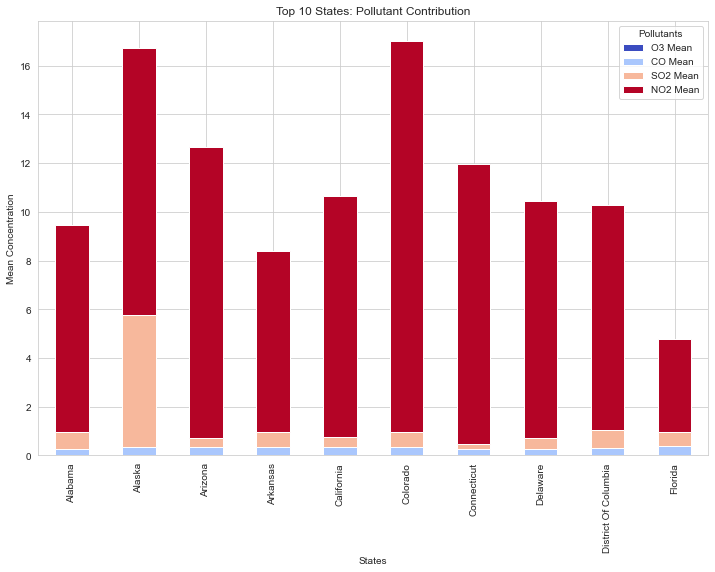

In [22]:

top_states = statewise_pollution.head(10)  
top_states.plot(kind='bar', stacked=True, figsize=(12, 8), colormap="coolwarm")
plt.title('Top 10 States: Pollutant Contribution')
plt.ylabel('Mean Concentration')
plt.xlabel('States')
plt.legend(title='Pollutants')
plt.show()

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.cm as cm

#  MongoDB to Jupyter

In [24]:

from pymongo import MongoClient
import pandas as pd


client = MongoClient("mongodb://localhost:27017/")


db = client['DAP']


emissions_collection = db['emissions']
emissions_data = emissions_collection.find({})  
emissions_df = pd.DataFrame(list(emissions_data))


heartcare_collection = db['heartcare']
heartcare_data = heartcare_collection.find({})  
heartcare_df = pd.DataFrame(list(heartcare_data))


print("Emissions DataFrame:")
print(emissions_df.head())  
print("\nHeartcare DataFrame:")
print(heartcare_df.head())  


client.close()


Emissions DataFrame:
                        _id  year state-name  \
0  675f99a553d8d27372d97b0c  1970    Alabama   
1  675f99a553d8d27372d97b0d  1970    Alabama   
2  675f99a553d8d27372d97b0e  1970    Alabama   
3  675f99a553d8d27372d97b0f  1970    Alabama   
4  675f99a553d8d27372d97b10  1970    Alabama   

                                       sector-name    fuel-name       value  
0              Industrial carbon dioxide emissions         Coal   26.721507  
1              Industrial carbon dioxide emissions    Petroleum    3.577779  
2              Industrial carbon dioxide emissions  Natural Gas    8.944097  
3              Industrial carbon dioxide emissions    All Fuels   39.243383  
4  Total carbon dioxide emissions from all sectors    All Fuels  102.646851  

Heartcare DataFrame:
                        _id       full_name  age country          state  \
0  675f99a553d8d27372da6509   Alice Johnson   21     USA           Utah   
1  675f99a553d8d27372da650a    Bob Williams   44  

In [25]:
heartcare_df.dtypes

_id                object
full_name          object
age                 int64
country            object
state              object
blood_pressure    float64
cholesterol       float64
bmi               float64
glucose_level     float64
gender             object
first_name         object
last_name          object
hospital           object
treatment          object
treatment_date     object
heart_disease       int64
dtype: object

In [26]:
print("Data Information:")
print(heartcare_df.info())

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   _id             10000 non-null  object 
 1   full_name       10000 non-null  object 
 2   age             10000 non-null  int64  
 3   country         10000 non-null  object 
 4   state           10000 non-null  object 
 5   blood_pressure  10000 non-null  float64
 6   cholesterol     10000 non-null  float64
 7   bmi             10000 non-null  float64
 8   glucose_level   10000 non-null  float64
 9   gender          10000 non-null  object 
 10  first_name      10000 non-null  object 
 11  last_name       10000 non-null  object 
 12  hospital        10000 non-null  object 
 13  treatment       10000 non-null  object 
 14  treatment_date  10000 non-null  object 
 15  heart_disease   10000 non-null  int64  
dtypes: float64(4), int64(2), object(10)
memory usage: 1.2+ MB
N

# EDA (Exploratory Data Analysis)

In [27]:
heartcare_df['treatment_date'] = pd.to_datetime(heartcare_df['treatment_date'])
heartcare_df['year_month'] = heartcare_df['treatment_date'].dt.to_period('M')

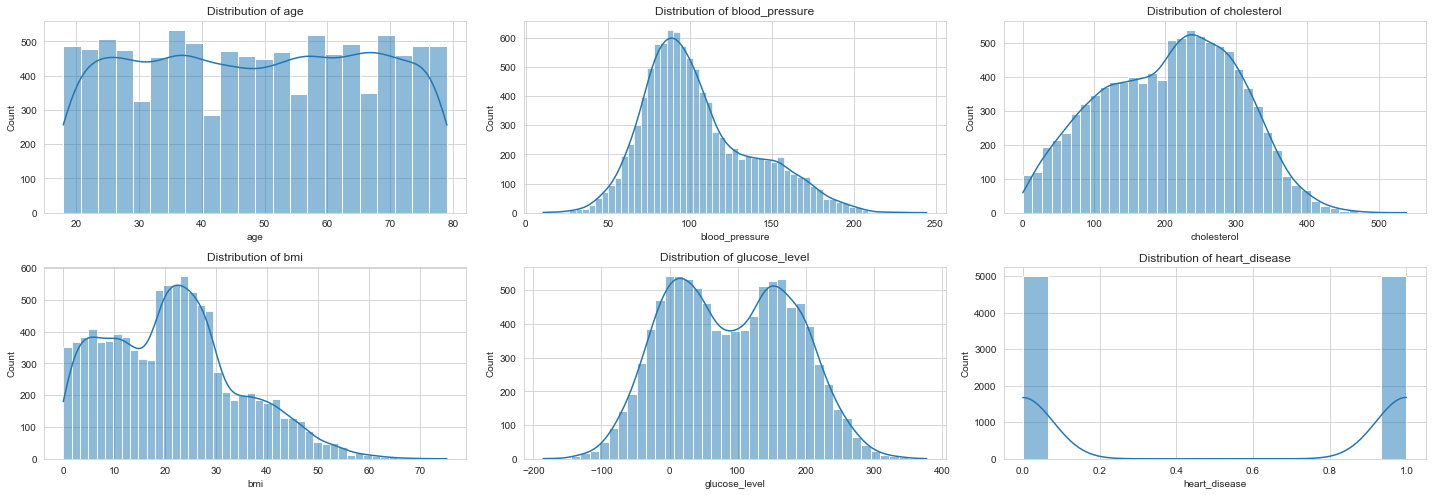

In [29]:
numerical_cols = ['age', 'blood_pressure', 'cholesterol', 'bmi', 'glucose_level', 'heart_disease']

plt.figure(figsize=(20, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(len(numerical_cols) // 3 + 1, 3, i)
    sns.histplot(heartcare_df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
plt.show()

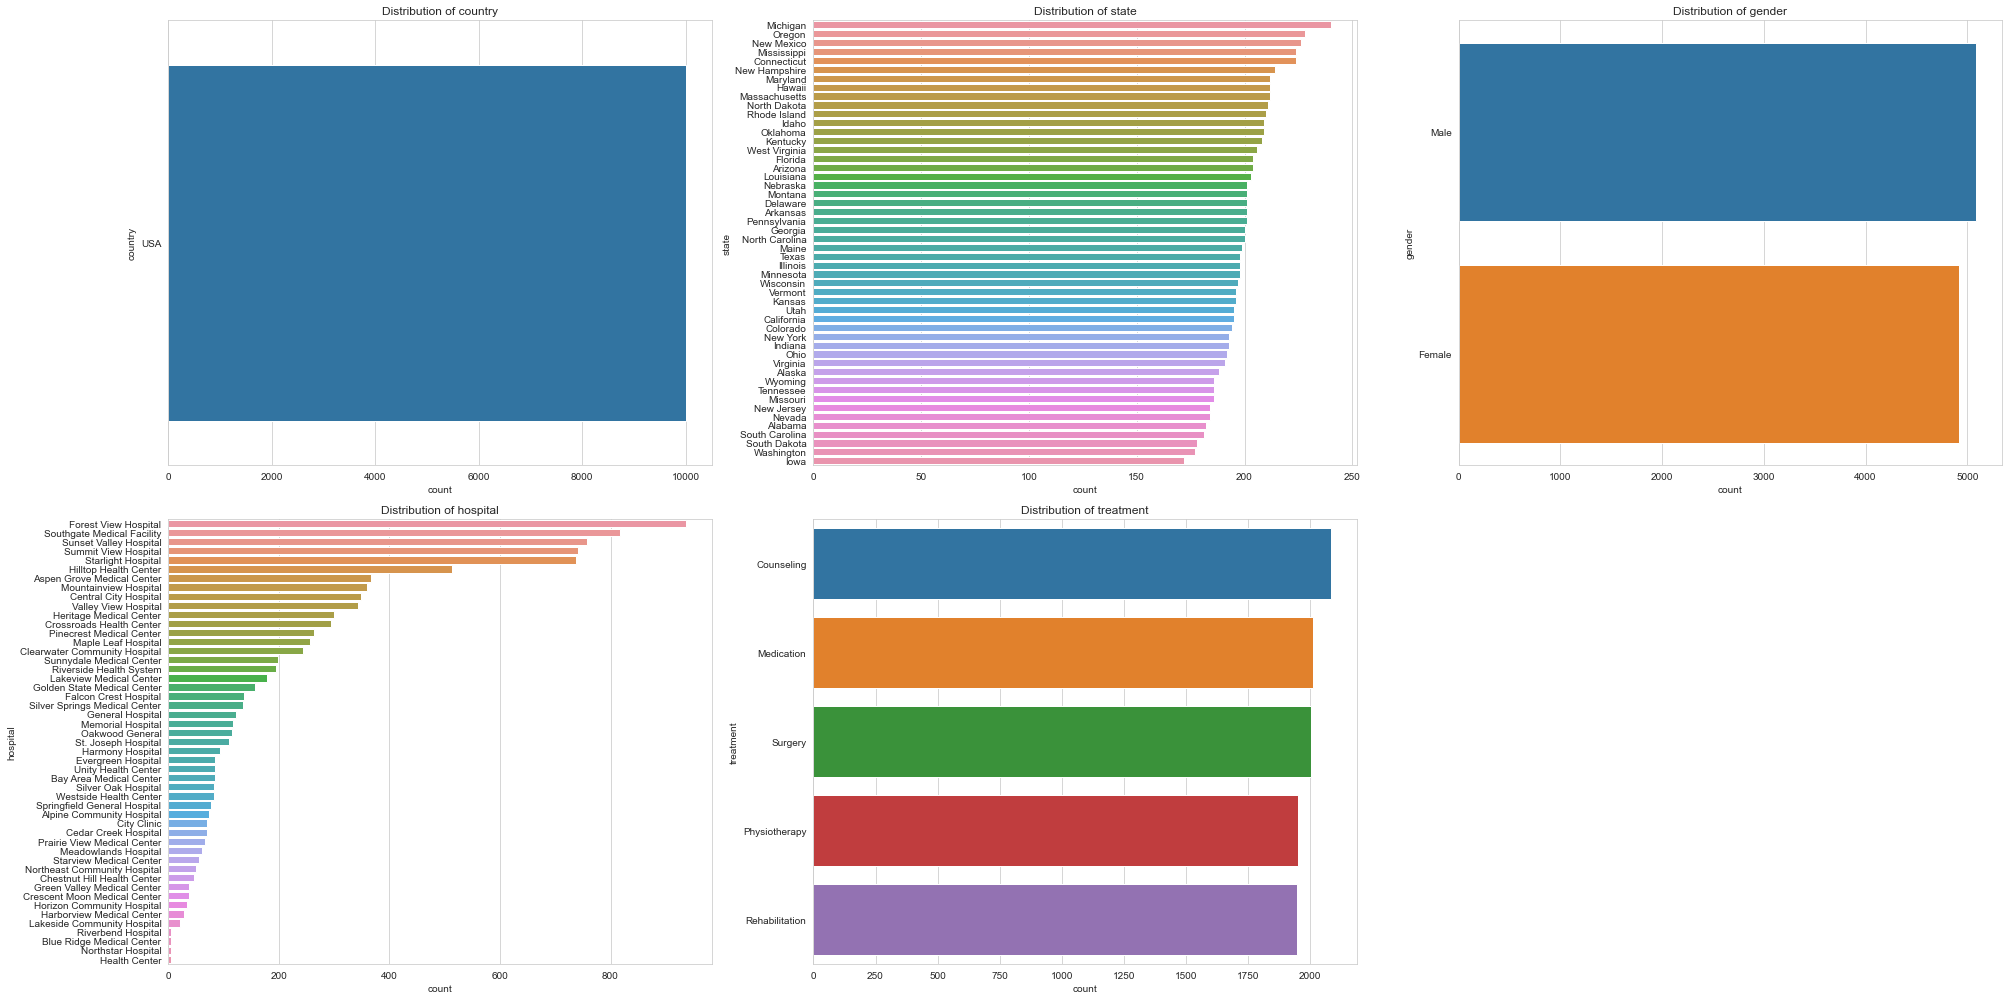

In [32]:
categorical_cols = ['country', 'state', 'gender', 'hospital', 'treatment']

plt.figure(figsize=(28, 14))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(len(categorical_cols) // 3 + 1, 3, i)
    sns.countplot(y=heartcare_df[col], order=heartcare_df[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
plt.show()

In [33]:
heartcare_df['treatment_date'] = pd.to_datetime(heartcare_df['treatment_date'])

heartcare_df['year'] = heartcare_df['treatment_date'].dt.year
heartcare_df['month'] = heartcare_df['treatment_date'].dt.month

heartcare_df = heartcare_df.drop(columns=['treatment_date'])


In [34]:
heartcare_df['year_month'] = heartcare_df['year'].astype(str) + '-' + heartcare_df['month'].astype(str).str.zfill(2)

In [35]:
heartcare_df.drop(['year_month'],axis=1,inplace=True)

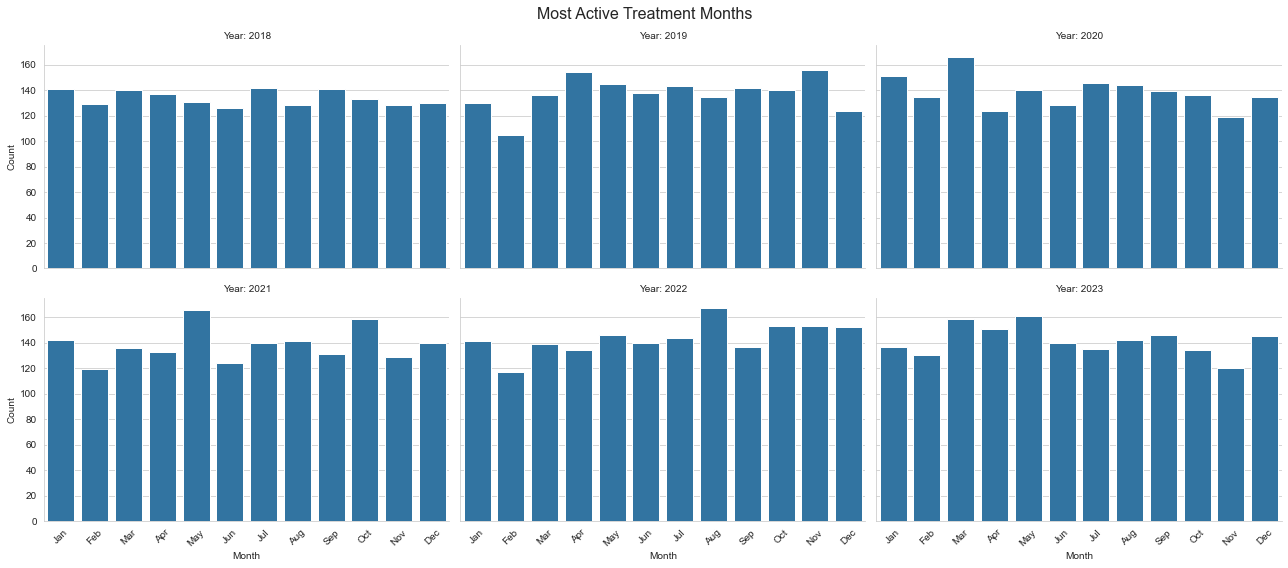

In [37]:
g = sns.FacetGrid(heartcare_df, col='year', col_wrap=3, height=4, aspect=1.5)
g.map(sns.countplot, 'month', order=range(1, 13))

g.set_axis_labels('Month', 'Count')
g.set_titles('Year: {col_name}')

month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for ax in g.axes.flat:
    ax.set_xticks(range(12))
    ax.set_xticklabels(month_labels, rotation=45)

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Most Active Treatment Months', fontsize=16)

plt.tight_layout()
plt.show()


In [38]:
heartcare_df['glucose_level'] = heartcare_df['glucose_level'].apply(lambda x: np.nan if x <= 0 else x)


<AxesSubplot:xlabel='age', ylabel='Count'>

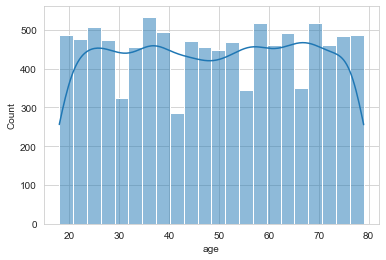

In [39]:
sns.histplot(data=heartcare_df, x='age', kde=True)

In [40]:
heartcare_df['glucose_level'] = heartcare_df.groupby(['gender', pd.cut(heartcare_df['age'], bins=[0, 20, 40, 60, 80, 100])])['glucose_level'].transform(
    lambda x: x.fillna(x.mean())
)

In [42]:
numeric_cols = ['blood_pressure', 'cholesterol', 'bmi', 'glucose_level']
correlation_matrix = heartcare_df[numeric_cols].corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)


Correlation Matrix:
                blood_pressure  cholesterol       bmi  glucose_level
blood_pressure        1.000000     0.269957  0.522376      -0.288829
cholesterol           0.269957     1.000000  0.359078       0.052493
bmi                   0.522376     0.359078  1.000000      -0.252329
glucose_level        -0.288829     0.052493 -0.252329       1.000000


In [43]:
heart_disease_counts = heartcare_df['heart_disease'].value_counts()
print("\nHeart Disease Cases:")
print(heart_disease_counts)


Heart Disease Cases:
1    5007
0    4993
Name: heart_disease, dtype: int64


In [44]:
mean_by_heart_disease = heartcare_df.groupby('heart_disease')[numeric_cols].mean()
print("\nMean Values by Heart Disease Status:")
print(mean_by_heart_disease)


Mean Values by Heart Disease Status:
               blood_pressure  cholesterol        bmi  glucose_level
heart_disease                                                       
0                   89.685486   205.399803  15.478942     121.161550
1                  119.947011   207.216335  27.340939     119.584754


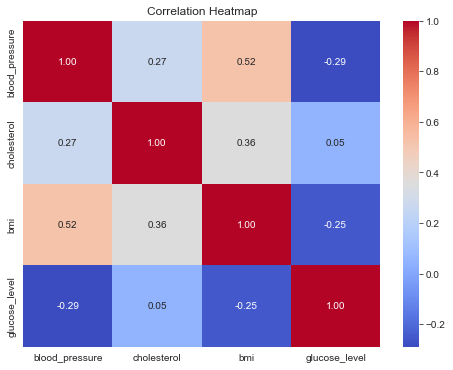

In [45]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

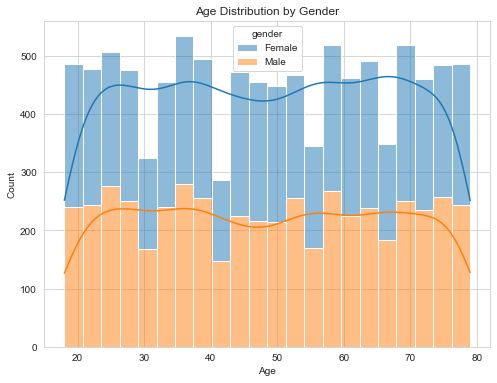

In [47]:
plt.figure(figsize=(8, 6))
sns.histplot(data=heartcare_df, x='age', hue='gender', kde=True, multiple='stack')
plt.title("Age Distribution by Gender")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()


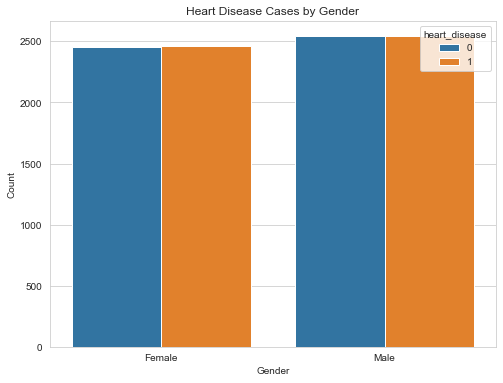

In [48]:
plt.figure(figsize=(8, 6))
sns.countplot(x='gender', hue='heart_disease', data=heartcare_df)
plt.title("Heart Disease Cases by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

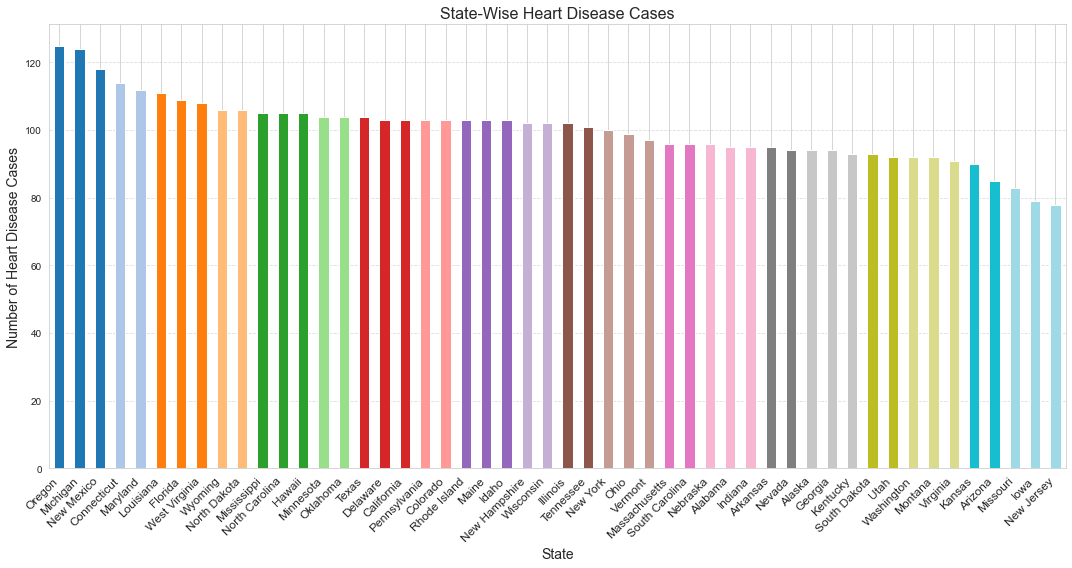

In [49]:
state_heart_disease = heartcare_df[heartcare_df['heart_disease'] == 1].groupby('state').size().sort_values(ascending=False)

num_states = len(state_heart_disease)
colors = cm.get_cmap('tab20', num_states).colors


plt.figure(figsize=(15, 8))
state_heart_disease.plot(kind='bar', color=colors)
plt.title('State-Wise Heart Disease Cases', fontsize=16)
plt.xlabel('State', fontsize=14)
plt.ylabel('Number of Heart Disease Cases', fontsize=14)


plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.tight_layout()

plt.show()


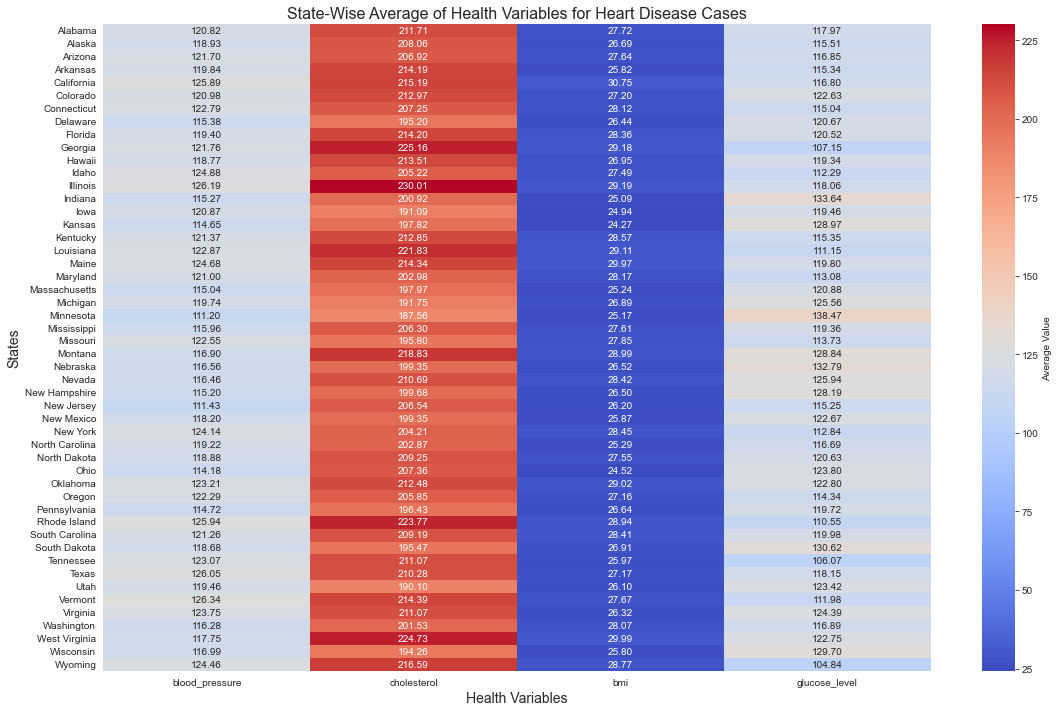

In [50]:
relevant_columns = ['state', 'blood_pressure', 'cholesterol', 'bmi', 'glucose_level', 'heart_disease']
heart_disease_data = heartcare_df[heartcare_df['heart_disease'] == 1][relevant_columns]

state_avg = heart_disease_data.groupby('state')[['blood_pressure', 'cholesterol', 'bmi', 'glucose_level']].mean()

plt.figure(figsize=(16, 10))
sns.heatmap(state_avg, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Average Value'})
plt.title('State-Wise Average of Health Variables for Heart Disease Cases', fontsize=16)
plt.xlabel('Health Variables', fontsize=14)
plt.ylabel('States', fontsize=14)
plt.tight_layout()

plt.show()


<AxesSubplot:xlabel='treatment', ylabel='bmi'>

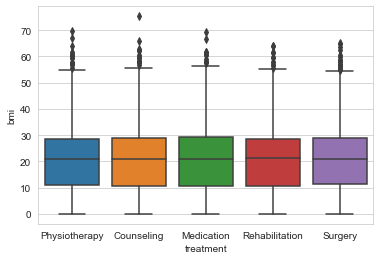

In [51]:
sns.boxplot(x='treatment', y='bmi', data=heartcare_df)

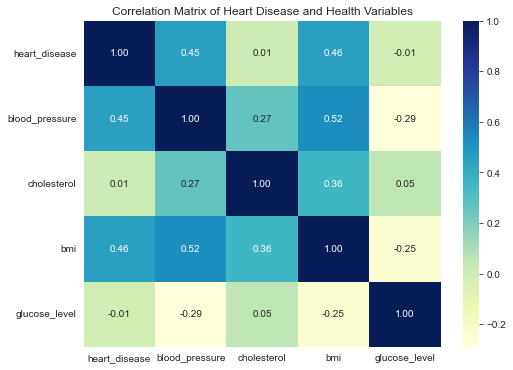

In [52]:
correlation_matrix = heartcare_df[['heart_disease', 'blood_pressure', 'cholesterol', 'bmi', 'glucose_level']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Correlation Matrix of Heart Disease and Health Variables')
plt.show()

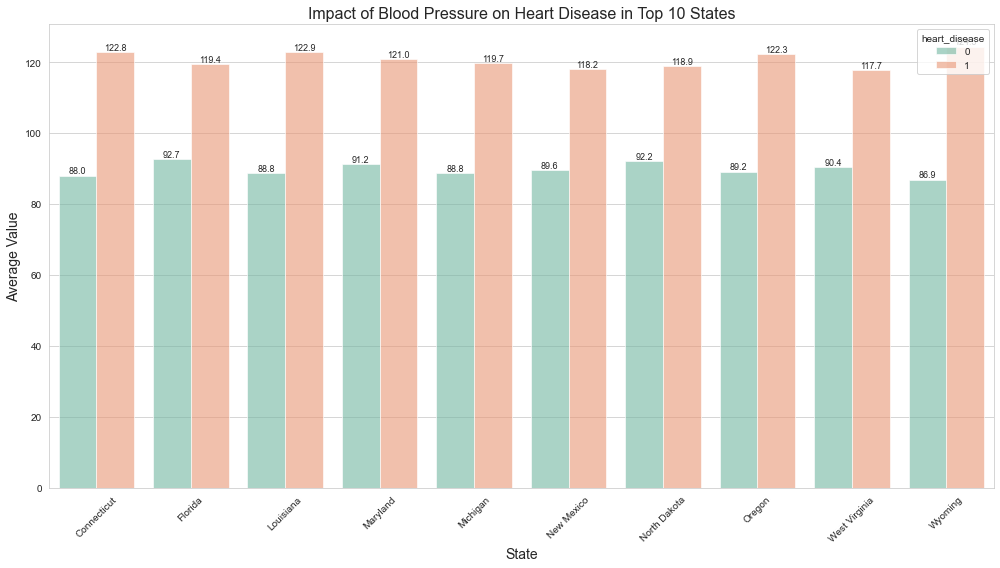

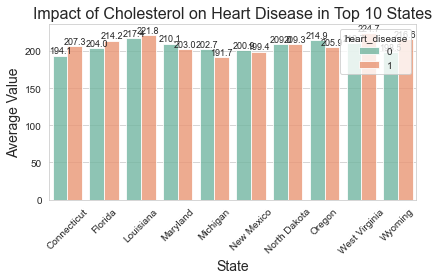

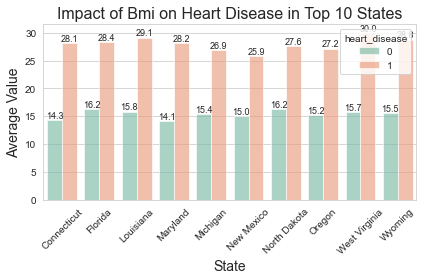

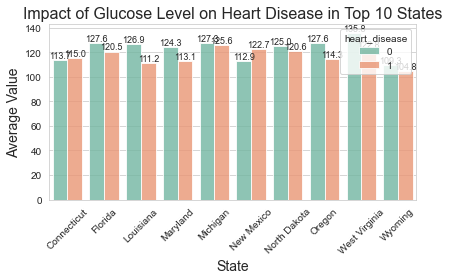

In [53]:
impact_analysis = heartcare_df.groupby(['state', 'heart_disease'])[['blood_pressure', 'cholesterol', 'bmi', 'glucose_level']].mean().reset_index()

total_heart_disease = heartcare_df.groupby('state')['heart_disease'].sum().reset_index()

top_states = total_heart_disease.nlargest(10, 'heart_disease')['state'].tolist()

top_states_data = impact_analysis[impact_analysis['state'].isin(top_states)]

plt.figure(figsize=(14, 8))

for idx, factor in enumerate(['blood_pressure', 'cholesterol', 'bmi', 'glucose_level']):
    bar_plot = sns.barplot(data=top_states_data, x='state', y=factor, hue='heart_disease', palette='Set2', alpha=0.6 if idx % 2 == 0 else 0.8, dodge=True)

    for p in bar_plot.patches:
        bar_plot.annotate(f'{p.get_height():.1f}', 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                          ha='center', va='bottom', fontsize=9)

    plt.title(f'Impact of {factor.replace("_", " ").title()} on Heart Disease in Top 10 States', fontsize=16)
    plt.ylabel('Average Value', fontsize=14)
    plt.xlabel('State', fontsize=14)
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()


In [54]:
heartcare_df['treatment'].unique()

array(['Physiotherapy', 'Counseling', 'Medication', 'Rehabilitation',
       'Surgery'], dtype=object)

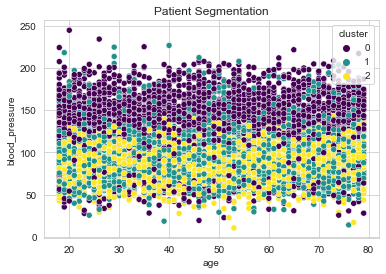

In [55]:
from sklearn.cluster import KMeans

features = heartcare_df[['age', 'blood_pressure', 'cholesterol', 'bmi', 'glucose_level']]
kmeans = KMeans(n_clusters=3)
heartcare_df['cluster'] = kmeans.fit_predict(features)
sns.scatterplot(x='age', y='blood_pressure', hue='cluster', data=heartcare_df, palette='viridis')
plt.title('Patient Segmentation')
plt.show()

In [56]:
bins = [0, 18, 30, 45, 60, 99]
labels = ['0-18', '19-30', '31-45', '46-60', '61-99']


heartcare_df['age_category'] = pd.cut(heartcare_df['age'], bins=bins, labels=labels, right=True)

print(heartcare_df[['age', 'age_category']].head())


   age age_category
0   21        19-30
1   44        31-45
2   22        19-30
3   19        19-30
4   64        61-99


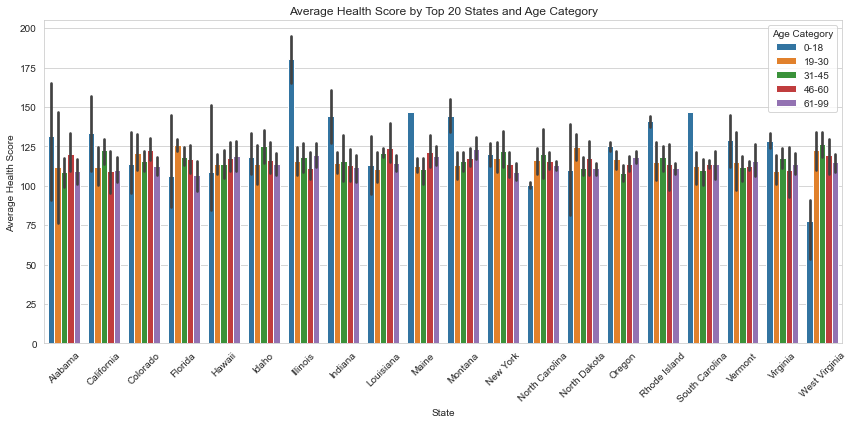

Less than 100 are Unfit
Between 100-160 are with Moderate health
More tha 160 are Fit


In [59]:
def health_score(row):
    
    return (row['blood_pressure'] + row['cholesterol'] + row['bmi'] + row['glucose_level']) / 4

heartcare_df['health_score'] = heartcare_df.apply(health_score, axis=1)

grouped_heartcare_df = heartcare_df.groupby(['state', 'age_category', 'treatment']).agg({
    'health_score': 'mean',
    'heart_disease': 'sum'
}).reset_index()

state_health_scores = grouped_heartcare_df.groupby('state')['health_score'].mean().reset_index()

top_20_states = state_health_scores.nlargest(20, 'health_score')

filtered_grouped_df = grouped_heartcare_df[grouped_heartcare_df['state'].isin(top_20_states['state'])]

plt.figure(figsize=(12, 6))
sns.barplot(data=filtered_grouped_df, x='state', y='health_score', hue='age_category')
plt.title('Average Health Score by Top 20 States and Age Category')
plt.xticks(rotation=45)
plt.ylabel('Average Health Score')
plt.xlabel('State')
plt.legend(title='Age Category')
plt.tight_layout()
plt.show()

print("Less than 100 are Unfit")
print("Between 100-160 are with Moderate health")
print("More tha 160 are Fit")

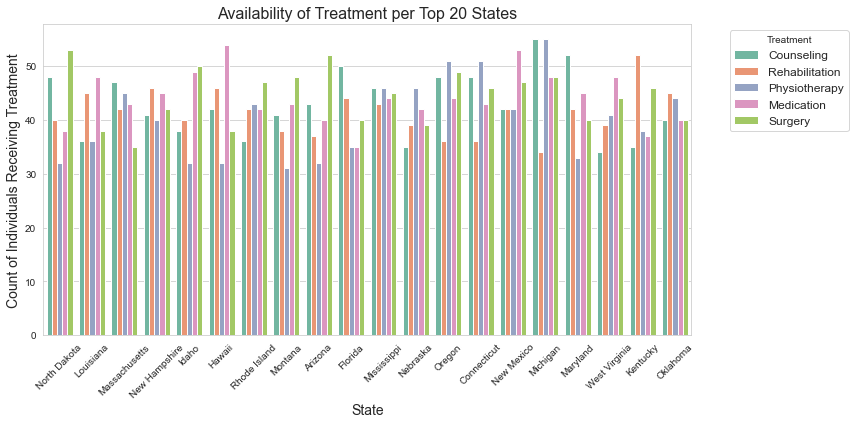

In [60]:
treatment_counts = heartcare_df['state'].value_counts().reset_index()
treatment_counts.columns = ['state', 'count']

top_20_states = treatment_counts.nlargest(20, 'count')['state']

filtered_df = heartcare_df[heartcare_df['state'].isin(top_20_states)]

plt.figure(figsize=(12, 6))
sns.countplot(data=filtered_df, x='state', hue='treatment', palette='Set2')

plt.title('Availability of Treatment per Top 20 States', fontsize=16)
plt.xlabel('State', fontsize=14)
plt.ylabel('Count of Individuals Receiving Treatment', fontsize=14)

plt.legend(title='Treatment', fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


# Emission

In [61]:
emissions_df = emissions_df[emissions_df['year'] >= 2018]
emissions_df

,_id,year,state-name,sector-name,fuel-name,value
55569,675f99a553d8d27372da541d,2018,Alabama,Residential carbon dioxide emissions,Petroleum,0.367080
55570,675f99a553d8d27372da541e,2018,Alabama,Residential carbon dioxide emissions,Natural Gas,1.887247
55571,675f99a553d8d27372da541f,2018,Alabama,Residential carbon dioxide emissions,All Fuels,2.254327
55572,675f99a553d8d27372da5420,2018,Alabama,Commercial carbon dioxide emissions,Petroleum,0.905405
55573,675f99a553d8d27372da5421,2018,Alabama,Commercial carbon dioxide emissions,Natural Gas,1.447565
...,...,...,...,...,...,...
59896,675f99a553d8d27372da6504,2021,Wyoming,Commercial carbon dioxide emissions,Coal,0.012374
59897,675f99a553d8d27372da6505,2021,Wyoming,Residential carbon dioxide emissions,All Fuels,0.937989
59898,675f99a553d8d27372da6506,2021,Wyoming,Residential carbon dioxide emissions,Natural Gas,0.717777
59899,675f99a553d8d27372da6507,2021,Wyoming,Residential carbon dioxide emissions,Petroleum,0.220212


In [62]:
emissions_df['sector-name'].unique()

array(['Residential carbon dioxide emissions',
       'Commercial carbon dioxide emissions',
       'Transportation carbon dioxide emissions',
       'Electric Power carbon dioxide emissions',
       'Industrial carbon dioxide emissions',
       'Total carbon dioxide emissions from all sectors'], dtype=object)

In [63]:
# Correct way to filter the DataFrame for the state "United States"
emissions_df = emissions_df[emissions_df['state-name'] != "United States"]
emissions_df

,_id,year,state-name,sector-name,fuel-name,value
55569,675f99a553d8d27372da541d,2018,Alabama,Residential carbon dioxide emissions,Petroleum,0.367080
55570,675f99a553d8d27372da541e,2018,Alabama,Residential carbon dioxide emissions,Natural Gas,1.887247
55571,675f99a553d8d27372da541f,2018,Alabama,Residential carbon dioxide emissions,All Fuels,2.254327
55572,675f99a553d8d27372da5420,2018,Alabama,Commercial carbon dioxide emissions,Petroleum,0.905405
55573,675f99a553d8d27372da5421,2018,Alabama,Commercial carbon dioxide emissions,Natural Gas,1.447565
...,...,...,...,...,...,...
59896,675f99a553d8d27372da6504,2021,Wyoming,Commercial carbon dioxide emissions,Coal,0.012374
59897,675f99a553d8d27372da6505,2021,Wyoming,Residential carbon dioxide emissions,All Fuels,0.937989
59898,675f99a553d8d27372da6506,2021,Wyoming,Residential carbon dioxide emissions,Natural Gas,0.717777
59899,675f99a553d8d27372da6507,2021,Wyoming,Residential carbon dioxide emissions,Petroleum,0.220212


In [64]:
emissions_df['fuel-name'].unique()

array(['Petroleum', 'Natural Gas', 'All Fuels', 'Coal'], dtype=object)

In [65]:
emissions_df.isnull().sum()

_id            0
year           0
state-name     0
sector-name    0
fuel-name      0
value          0
dtype: int64

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [67]:

top_states = emissions_df.groupby('state-name')['value'].sum().nlargest(10).index


emissions_df_top_states = emissions_df[emissions_df['state-name'].isin(top_states)]

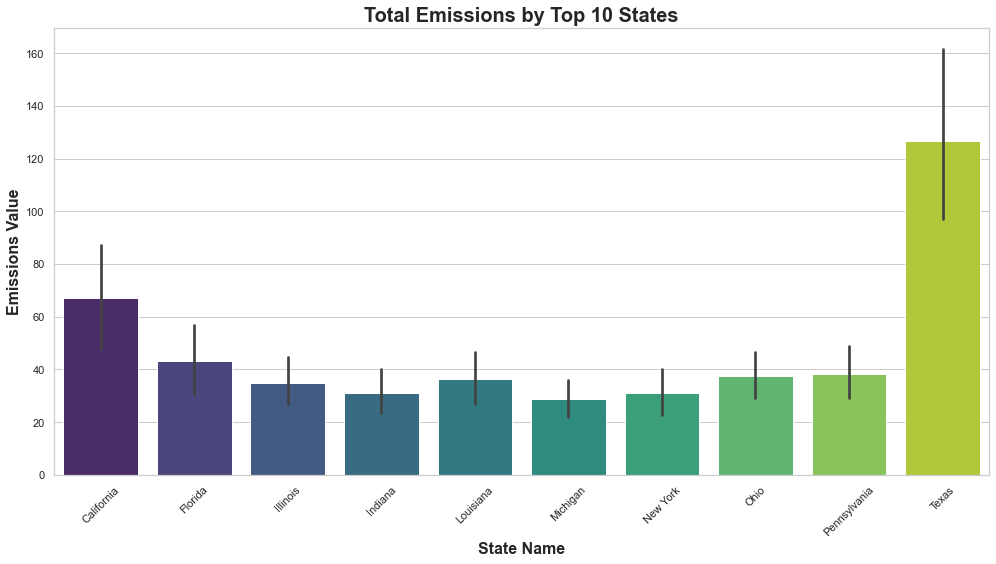

In [69]:
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")


sns.barplot(data=emissions_df_top_states, x='state-name', y='value', palette="viridis")
plt.title('Total Emissions by Top 10 States', fontsize=20, weight='bold')
plt.xlabel('State Name', fontsize=16, weight='bold')
plt.ylabel('Emissions Value', fontsize=16, weight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


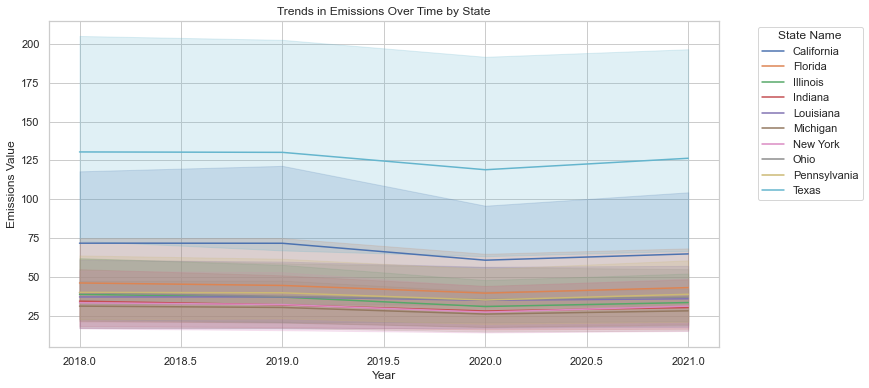

In [70]:

plt.figure(figsize=(12, 6))
sns.lineplot(data=emissions_df_top_states, x='year', y='value', hue='state-name')
plt.title('Trends in Emissions Over Time by State')
plt.xlabel('Year')
plt.ylabel('Emissions Value')
plt.legend(title='State Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


<Figure size 1008x576 with 0 Axes>

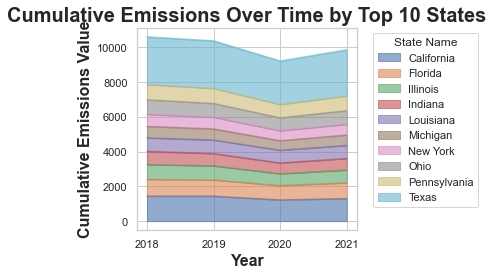

In [71]:
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")


df_pivot = emissions_df_top_states.pivot_table(values='value', index='year', columns='state-name', aggfunc='sum').fillna(0)
df_pivot.plot.area(alpha=0.6)
plt.title('Cumulative Emissions Over Time by Top 10 States', fontsize=20, weight='bold')
plt.xlabel('Year', fontsize=16, weight='bold')
plt.ylabel('Cumulative Emissions Value', fontsize=16, weight='bold')
plt.legend(title='State Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


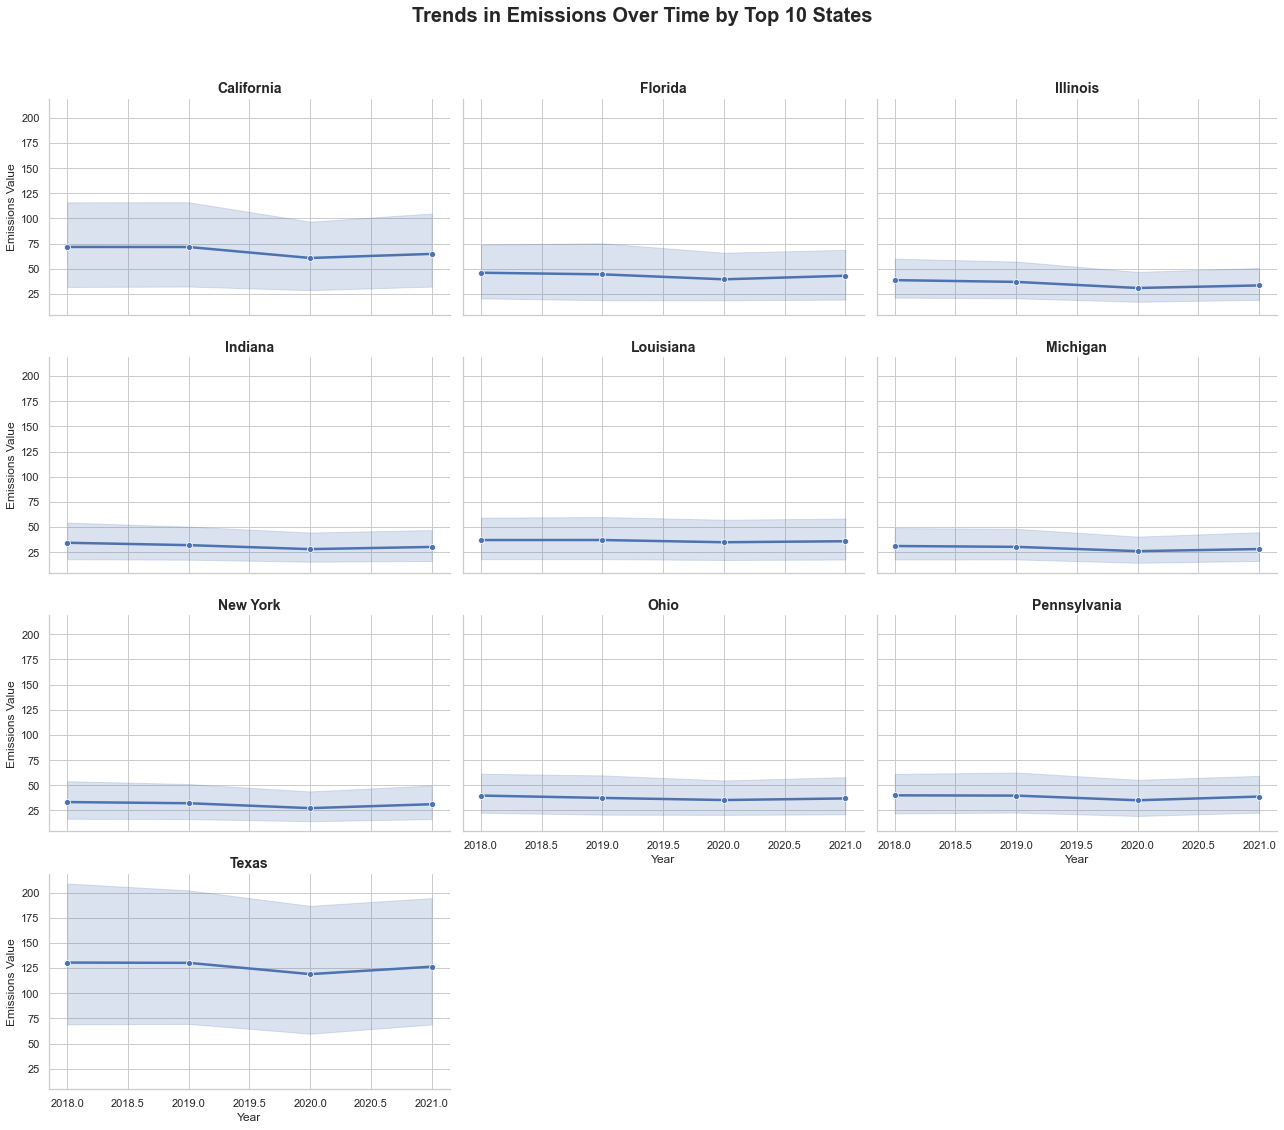

In [72]:
g = sns.FacetGrid(emissions_df_top_states, col='state-name', col_wrap=3, height=4, aspect=1.5)
g.map(sns.lineplot, 'year', 'value', marker="o", linewidth=2.5)
g.set_titles(col_template='{col_name}', size=14, weight='bold')
g.set_axis_labels('Year', 'Emissions Value', fontsize=12)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Trends in Emissions Over Time by Top 10 States', fontsize=20, weight='bold')
plt.show()

C:\Users\malav\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 15.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\malav\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 38.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\malav\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 27.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\malav\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 31.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\malav\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 28.6% of the points

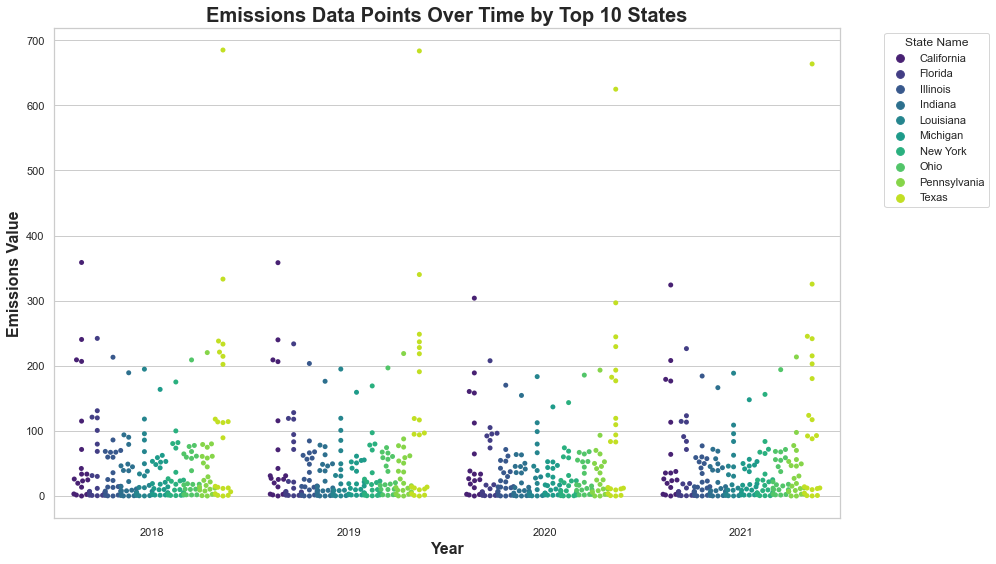

In [73]:
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")

sns.swarmplot(data=emissions_df_top_states, x='year', y='value', hue='state-name', palette="viridis", dodge=True)
plt.title('Emissions Data Points Over Time by Top 10 States', fontsize=20, weight='bold')
plt.xlabel('Year', fontsize=16, weight='bold')
plt.ylabel('Emissions Value', fontsize=16, weight='bold')
plt.legend(title='State Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


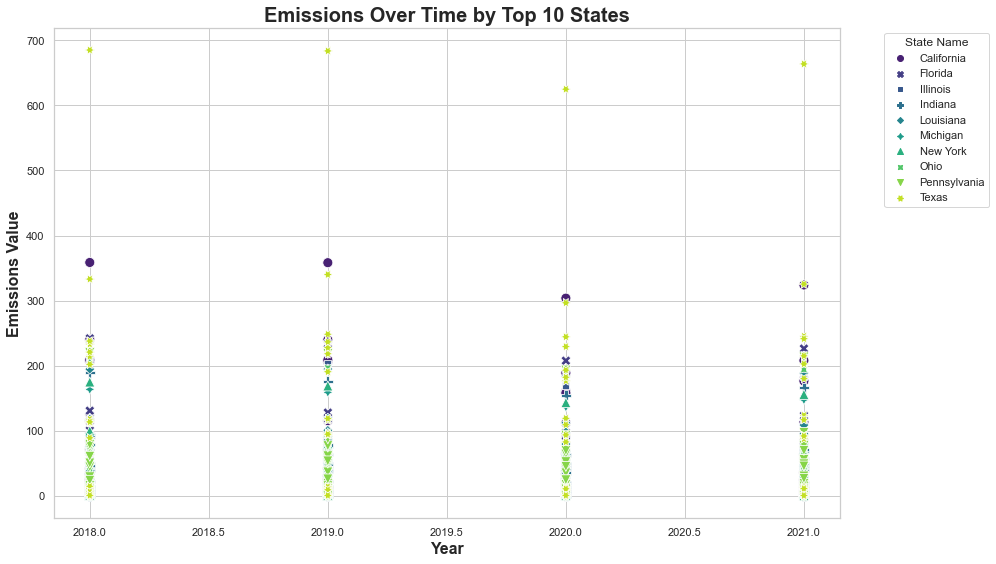

In [74]:
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")

sns.scatterplot(data=emissions_df_top_states, x='year', y='value', hue='state-name', style='state-name', s=100, palette="viridis", markers=True)
plt.title('Emissions Over Time by Top 10 States', fontsize=20, weight='bold')
plt.xlabel('Year', fontsize=16, weight='bold')
plt.ylabel('Emissions Value', fontsize=16, weight='bold')
plt.legend(title='State Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


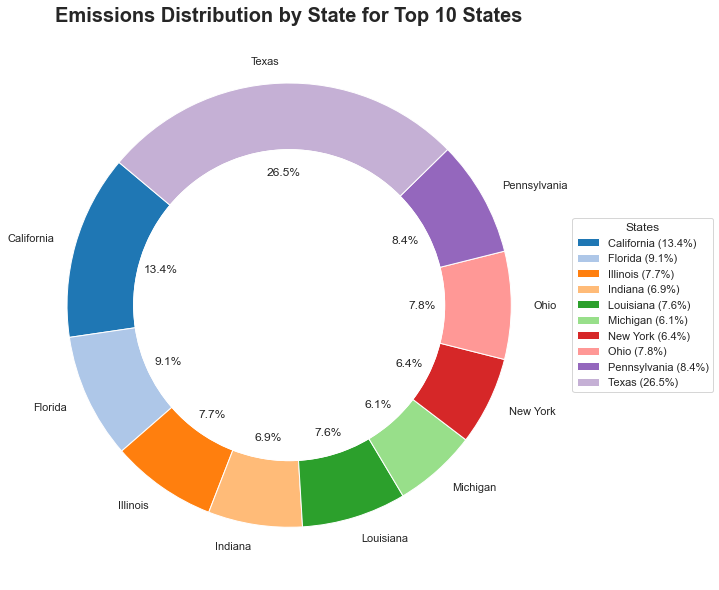

In [75]:
import pandas as pd
import matplotlib.pyplot as plt


top_states = emissions_df.groupby('state-name')['value'].sum().nlargest(10).index


df_top_states = emissions_df[emissions_df['state-name'].isin(top_states)]


emissions_by_state = df_top_states.groupby('state-name')['value'].sum()


plt.figure(figsize=(10, 10))


colors = plt.get_cmap('tab20')(range(len(emissions_by_state)))


wedges, texts, autotexts = plt.pie(emissions_by_state, labels=emissions_by_state.index,
                                   autopct='%1.1f%%', startangle=140, colors=colors, wedgeprops=dict(width=0.3))


centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)


plt.legend(wedges, [f"{state} ({percent:.1f}%)" for state, percent in zip(emissions_by_state.index, emissions_by_state/emissions_by_state.sum()*100)],
           title="States", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))


plt.title('Emissions Distribution by State for Top 10 States', fontsize=20, weight='bold')
plt.tight_layout()
plt.show()


<Figure size 1008x576 with 0 Axes>

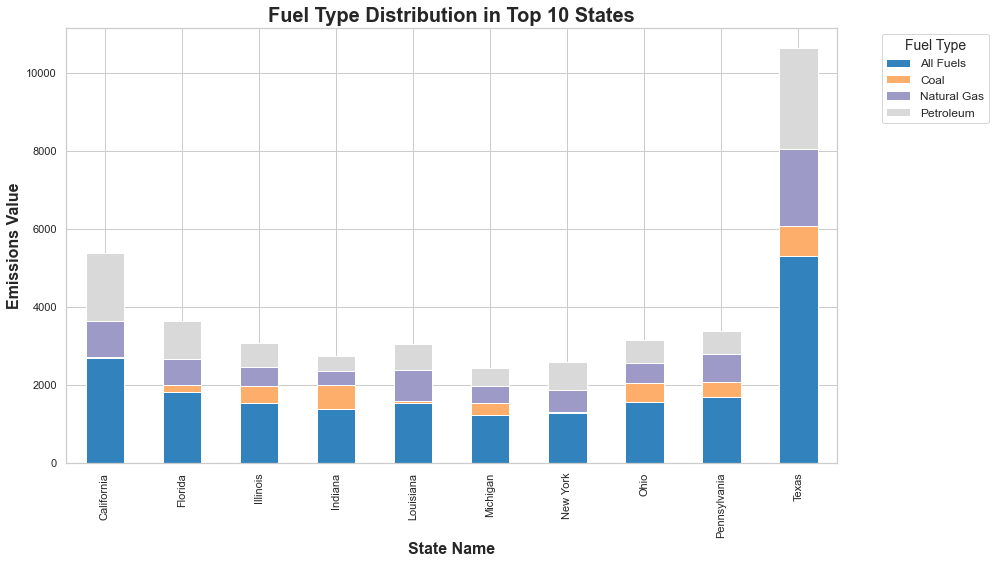

In [76]:
import pandas as pd
import matplotlib.pyplot as plt



top_states = emissions_df.groupby('state-name')['value'].sum().nlargest(10).index


df_top_states = emissions_df[emissions_df['state-name'].isin(top_states)]


emissions_by_state_fuel = df_top_states.groupby(['state-name', 'fuel-name'])['value'].sum().unstack().fillna(0)


plt.figure(figsize=(14, 8))


emissions_by_state_fuel.plot(kind='bar', stacked=True, colormap='tab20c', figsize=(14, 8))


plt.title('Fuel Type Distribution in Top 10 States', fontsize=20, weight='bold')
plt.xlabel('State Name', fontsize=16, weight='bold')
plt.ylabel('Emissions Value', fontsize=16, weight='bold')


plt.legend(title='Fuel Type', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)

plt.tight_layout()
plt.show()


# save Json data to PostgreSQL

In [77]:
from bson import ObjectId


def convert_objectid_to_string(df):
    
    for col in df.columns:
        if isinstance(df[col].iloc[0], ObjectId):  
            df[col] = df[col].apply(lambda x: str(x) if isinstance(x, ObjectId) else x)
    return df

# Save Heartcare Data
def save_heartcare_data(df_heartcare):
    table_name = "heartcare_data"  
    try:
        
        df_heartcare = convert_objectid_to_string(df_heartcare)

        
        df_heartcare.to_sql(table_name, con=engine, if_exists='replace', index=False)
        print(f"Heartcare data successfully saved to PostgreSQL table '{table_name}'.")
    except Exception as e:
        print(f"Error saving heartcare data to PostgreSQL: {e}")


def save_emissions_data(df_emissions):
    table_name = "emissions_data" 
    try:
        
        df_emissions = convert_objectid_to_string(df_emissions)

        
        df_emissions.to_sql(table_name, con=engine, if_exists='replace', index=False)
        print(f"Emissions data successfully saved to PostgreSQL table '{table_name}'.")
    except Exception as e:
        print(f"Error saving emissions data to PostgreSQL: {e}")


try:
    print("Saving Heartcare Data...")
    save_heartcare_data(heartcare_df)

    print("\nSaving Emissions Data...")
    save_emissions_data(emissions_df)

except Exception as main_e:
    print(f"An error occurred while saving data: {main_e}")

finally:
    print("\nData saving process completed.")


Saving Heartcare Data...
Heartcare data successfully saved to PostgreSQL table 'heartcare_data'.

Saving Emissions Data...
Emissions data successfully saved to PostgreSQL table 'emissions_data'.

Data saving process completed.


C:\Users\malav\AppData\Local\Temp\ipykernel_27620\1294287886.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(lambda x: str(x) if isinstance(x, ObjectId) else x)


# Dashboard

In [79]:
import plotly.express as px
import plotly.graph_objects as go
from dash import Dash, dcc, html, Input, Output
 

pollution_df['Date'] = pd.to_datetime(pollution_df['Date'])
pollution_df['Year'] = pollution_df['Date'].dt.year
 

pollution_df = pollution_df[pollution_df['Year'] >= 2000]
emissions_df = emissions_df[emissions_df['year'] >= 2000]
 

pollution_summary = pollution_df.groupby('Year')[['O3 Mean', 'CO Mean', 'SO2 Mean', 'NO2 Mean']].mean()
normalized_pollution = pollution_summary / pollution_summary.max()
 
emissions_summary = emissions_df.groupby(['state-name', 'fuel-name'])['value'].sum().unstack().fillna(0)
top_emission_states = emissions_df.groupby('state-name')['value'].sum().nlargest(10).index
emissions_top_states = emissions_df[emissions_df['state-name'].isin(top_emission_states)]
 

fuel_distribution = emissions_df.groupby(['year', 'fuel-name'])['value'].sum().unstack().fillna(0)
 

def health_score(row):
    return (row['blood_pressure'] + row['cholesterol'] + row['bmi'] + row['glucose_level']) / 4
 
heartcare_df['health_score'] = heartcare_df.apply(health_score, axis=1)
health_scores = heartcare_df.groupby(['state', 'age_category', 'treatment'])['health_score'].mean().reset_index()
top_health_states = health_scores.groupby('state')['health_score'].mean().nlargest(20).index
filtered_health_scores = health_scores[health_scores['state'].isin(top_health_states)]
 

app = Dash(__name__)
 
app.layout = html.Div([
   
    html.Div([
        html.H1("Environmental and Health Insights Dashboard", style={'textAlign': 'center'}),
        html.P("Explore trends in emissions, pollution, and health metrics across U.S. states.",
               style={'textAlign': 'center', 'fontSize': '16px'})
    ], style={'backgroundColor': '#f4f4f4', 'padding': '10px'}),
 
    
    html.Div([
        html.Label("Select a State:", style={'fontSize': '18px', 'fontWeight': 'bold'}),
        dcc.Dropdown(
            id='state-dropdown',
            options=[{'label': state, 'value': state} for state in emissions_df['state-name'].unique()],
            value='California',
            clearable=False,
            style={'width': '50%', 'margin': 'auto'}
        )
    ], style={'textAlign': 'center', 'marginBottom': '20px'}),
 
    
    dcc.Tabs([
        dcc.Tab(label='Emissions', children=[
            dcc.Graph(id='emissions-chart')
        ]),
        dcc.Tab(label='Sector Analysis', children=[
            html.Div([
                html.Label("Select Year:"),
                dcc.Dropdown(
                    id='year-dropdown',
                    options=[{'label': year, 'value': year} for year in emissions_df['year'].unique()],
                    value=emissions_df['year'].max(),
                    clearable=False
                )
            ], style={'width': '30%', 'margin': 'auto'}),
            html.Div([
                html.Label("Select Fuel Name:"),
                dcc.Dropdown(
                    id='fuel-dropdown',
                    options=[{'label': fuel, 'value': fuel} for fuel in emissions_df['fuel-name'].unique()],
                    value=emissions_df['fuel-name'].unique()[0],
                    clearable=False
                )
            ], style={'width': '30%', 'margin': 'auto'}),
            dcc.Graph(id='sector-chart')
        ]),
        dcc.Tab(label='Health Scores', children=[
            dcc.Graph(id='health-score-chart')
        ]),
        dcc.Tab(label='Treatment Availability', children=[
            dcc.Graph(id='treatment-chart')
        ]),
        dcc.Tab(label='Pollutant Trends', children=[
            dcc.Graph(id='pollutant-trends-chart')
        ]),
        dcc.Tab(label='Fuel Distribution', children=[
            dcc.Graph(id='fuel-distribution-chart')
        ])
    ])
], style={'width': '80%', 'margin': 'auto'})
 

@app.callback(
    [Output('emissions-chart', 'figure'),
     Output('sector-chart', 'figure'),
     Output('health-score-chart', 'figure'),
     Output('treatment-chart', 'figure'),
     Output('pollutant-trends-chart', 'figure'),
     Output('fuel-distribution-chart', 'figure')],
    [Input('state-dropdown', 'value'),
     Input('year-dropdown', 'value'),
     Input('fuel-dropdown', 'value')]
)
def update_dashboard(selected_state, selected_year, selected_fuel):
    
    state_emissions = emissions_summary.loc[selected_state] if selected_state in emissions_summary.index else pd.Series()
    state_emissions = state_emissions.reset_index()
    state_emissions.columns = ['fuel-name', 'value']
    emissions_fig = px.pie(
        state_emissions, values='value', names='fuel-name',
        title=f'Fuel Type Distribution for {selected_state}',
        hole=0.3
    )
 
    
    sector_data = emissions_df[(emissions_df['state-name'] == selected_state) &
                               (emissions_df['year'] == selected_year) &
                               (emissions_df['fuel-name'] == selected_fuel)]
    sector_fig = px.bar(
        sector_data, x='sector-name', y='value',
        title=f'Sector-wise Emissions for {selected_state} ({selected_year}, {selected_fuel})',
        labels={'value': 'Emissions', 'sector-name': 'Sector'}
    )
 
    
    pollutant_fig = go.Figure()
    for pollutant in normalized_pollution.columns:
        pollutant_fig.add_trace(go.Scatter(
            x=normalized_pollution.index, y=normalized_pollution[pollutant],
            mode='lines+markers', name=pollutant
        ))
    pollutant_fig.update_layout(
        title="Yearly Trends of Pollutants (Normalized)",
        xaxis_title="Year", yaxis_title="Normalized Concentration",
        legend_title="Pollutants"
    )
 
    
    filtered_scores = filtered_health_scores[filtered_health_scores['state'] == selected_state]
    health_fig = px.bar(
        filtered_scores, x='age_category', y='health_score', color='treatment',
        title=f'Health Scores for {selected_state}',
        labels={'health_score': 'Health Score', 'age_category': 'Age Category'}
    )
 
   
    state_treatment = heartcare_df[heartcare_df['state'] == selected_state]
    treatment_fig = px.histogram(
        state_treatment, x='treatment',
        title=f'Treatment Availability in {selected_state}',
        labels={'count': 'Number of Treatments', 'treatment': 'Treatment Type'}
    )
 
   
    fuel_fig = px.bar(
        fuel_distribution, barmode='stack',
        title="Fuel Type Distribution by Year (2000 onwards)",
        labels={'value': 'Emissions', 'year': 'Year'},
        color_discrete_sequence=px.colors.qualitative.Pastel
    )
 
    return emissions_fig, sector_fig, health_fig, treatment_fig, pollutant_fig, fuel_fig
 

if __name__ == '__main__':
    app.run_server(debug=True, port=8051)